In [2]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from __future__ import print_function
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, mean_squared_error

from keras.models import Sequential, Model, load_model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Activation, Dropout, BatchNormalization
from keras import regularizers, initializers
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier

from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc

Using TensorFlow backend.


In [3]:
def getFormat(df, train_raw, window_size, stride):
    x = []
    for i in df:
        x.append(train_raw[i + 750 : i + 1750])
    x = np.array(x)
    x = x.reshape(-1, x.shape[2])
    upsample = []
    for i in range(0, len(x), stride):
        if(i + window_size <= len(x)):
            upsample.append(np.array(x[i: i + window_size]).flatten())
    return np.array(upsample)

def getData(subject, window_size, stride):
    train_raw = pd.read_csv("data/" + subject + "_data.csv", header=None).fillna(method='ffill').values
    print(train_raw.shape)
    markers_raw = pd.read_csv("data/" + subject + "_markers.csv", header=None)
    markers_raw.dropna(inplace=True)
    markers_raw.reset_index(drop=True, inplace=True)
    
    mr1 = markers_raw[markers_raw[1] == 1][0]
    mr2 = markers_raw[markers_raw[1] == 2][0]
    mr3 = markers_raw[markers_raw[1] == 3][0]
    mr4 = markers_raw[markers_raw[1] == 4][0]
  
    X1, X2, X3, X4 = [getFormat(mr, train_raw, window_size, stride) for mr in [mr1, mr2, mr3, mr4]]
    Y = [0] * len(X1) + [1] * len(X2) + [2] * len(X3) + [3] * len(X4)
  
  
    X = np.append(X1, X2, axis = 0)
    X = np.append(X, X3, axis = 0)
    X = np.append(X, X4, axis = 0)
  
    print(X.shape)
    sc = preprocessing.StandardScaler()
    X = sc.fit_transform(X)
  
    return X, Y

In [4]:
def getReport(y_train, y_test, y_tr_pred, y_pred):
    accuracy = accuracy_score(np.argmax(y_pred, axis=1), y_test)
    tr_accuracy = accuracy_score(np.argmax(y_tr_pred, axis=1), y_train)
    precision = precision_score(np.argmax(y_pred, axis=1), y_test, average=None)
    recall = recall_score(np.argmax(y_pred, axis=1), y_test, average=None)
    f1 = f1_score(np.argmax(y_pred, axis=1),y_test, average=None)
    rmse = mean_squared_error(np.argmax(y_pred, axis=1),y_test)
    print({"rmse": rmse, "tr_acc": tr_accuracy, "acc": accuracy, "pre": precision, "rec": recall, "f1s": f1})

    return accuracy, tr_accuracy, precision, recall, f1, rmse

In [33]:
def autoencode(X_train, X_test, epochs=200, batch=128):
    n_input = X_train.shape[1]
    model = Sequential()
    model.add(Dense(1024, kernel_initializer=initializers.he_normal(), input_shape=(n_input, ), activation='tanh'))
    model.add(BatchNormalization())
    model.add(Dense(512, kernel_initializer=initializers.he_normal(), activation='tanh'))
    model.add(BatchNormalization())
    model.add(Dense(256, kernel_initializer=initializers.he_normal(), activation='tanh'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(512, kernel_initializer=initializers.he_normal(), activation='tanh'))
    model.add(BatchNormalization())
    model.add(Dense(1024, kernel_initializer=initializers.he_normal(), activation='tanh'))
    model.add(BatchNormalization())
    model.add(Dense(n_input, kernel_initializer=initializers.he_normal(), activation='tanh'))
    model.compile(optimizer='adam', loss='mse')
    model.summary()
    filepath="weights/temp/autoenc-weights.hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
    callbacks_list = [checkpoint]
    model.fit(X_train, X_train,
                epochs=epochs,
                batch_size=batch,
                validation_data=[X_test, X_test], callbacks=callbacks_list, verbose=2)  
    del model
    bestmodel = Sequential()
    bestmodel = load_model(filepath)
    X_pred = bestmodel.predict(X_train)
    loss = mean_squared_error(X_train, X_pred)
    return bestmodel, loss

In [34]:
def buildClassifier(subject, X_train, X_test, y_train, y_test, 
                    ae_epochs=200, ae_batch=128, 
                    cf_epochs=100, cf_batch=64):
    autoencoder, loss = autoencode(X_train, X_test, ae_epochs, ae_batch)
    for layer in autoencoder.layers[ 0 : 6 ]:
        layer.trainable = False

    for _ in range(6):
        autoencoder.pop()

    autoencoder.outputs = [autoencoder.layers[-1].output]
    autoencoder.layers[-1].outbound_nodes = []
    autoencoder.summary()
    autoencoder.add(Dense(4, activation='softmax', kernel_initializer=initializers.he_normal()))
    autoencoder.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    autoencoder.summary()
    filepath="weights/AE/1024-512-256/" + subject + "-weights.hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [checkpoint]
    autoencoder.fit(X_train, y_train,
                epochs=cf_epochs,
                batch_size=cf_batch,
                shuffle=True,
                validation_data=[X_test, y_test],
                callbacks=callbacks_list,
                verbose=2)
    del autoencoder
    bestmodel = load_model(filepath)
    return bestmodel, loss

In [35]:
def runmodel(subject, epochs=200, batch=64, window_size=125, stride=100, 
             ae_epochs=200, ae_batch=64, cf_epochs=200, cf_batch=64):
    X, y = getData(subject, window_size=window_size, stride=stride)
    y = np.array(y)
    seed = 7
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
    cvscores = []
    tr_acc, acc, pre, rec, f, rms = 0, 0, 0, 0, 0, 0
    for train, test in kfold.split(X, y):
        y_train = to_categorical(y[train])
        y_test = to_categorical(y[test])
        model, ae_loss = buildClassifier(subject, X[train], 
                              X[test], 
                              y_train, 
                              y_test, ae_epochs, ae_batch, cf_epochs, cf_batch)
        y_pred = model.predict(X[test])
        y_tr_pred = model.predict(X[train])

        accuracy, tr_accuracy, precision, recall, f1, rmse = getReport(y[train], y[test], y_tr_pred, y_pred)
        return {"rmse": rmse, "tr_acc": tr_accuracy, "acc": accuracy, "pre": precision, "rec": recall, "f1s": f1}
        rms = rms + rmse / 10
        tr_acc = tr_acc + tr_accuracy / 10
        acc = acc + accuracy / 10
        rec = rec + recall / 10
        pre = pre + precision / 10
        f = f + f1 / 10
        break
    return {"rmse": rms, "tr_acc": tr_acc, "acc": acc, "pre": pre, "rec": rec, "f1s": f}

In [36]:
reports = []
for subject in ['k3b', 'k6b', 'l1b'] :
    report = {
      "subject": subject,
      "report": runmodel(subject, ae_epochs=300, cf_epochs=300, ae_batch=256, cf_batch=64, window_size=125, stride=100)
    }
    reports.append(report)

(986780, 60)
(1796, 7500)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_72 (Dense)             (None, 1024)              7681024   
_________________________________________________________________
batch_normalization_56 (Batc (None, 1024)              4096      
_________________________________________________________________
dense_73 (Dense)             (None, 512)               524800    
_________________________________________________________________
batch_normalization_57 (Batc (None, 512)               2048      
_________________________________________________________________
dense_74 (Dense)             (None, 256)               131328    
_________________________________________________________________
batch_normalization_58 (Batc (None, 256)               1024      
_________________________________________________________________
dropout_11 (Dropout)         (None, 256)          

Epoch 41/300
 - 4s - loss: 0.3916 - val_loss: 0.4799

Epoch 00041: loss improved from 0.39418 to 0.39156, saving model to weights/temp/autoenc-weights.hdf5
Epoch 42/300
 - 3s - loss: 0.3885 - val_loss: 0.4784

Epoch 00042: loss improved from 0.39156 to 0.38847, saving model to weights/temp/autoenc-weights.hdf5
Epoch 43/300
 - 3s - loss: 0.3855 - val_loss: 0.4777

Epoch 00043: loss improved from 0.38847 to 0.38545, saving model to weights/temp/autoenc-weights.hdf5
Epoch 44/300
 - 3s - loss: 0.3826 - val_loss: 0.4744

Epoch 00044: loss improved from 0.38545 to 0.38261, saving model to weights/temp/autoenc-weights.hdf5
Epoch 45/300
 - 3s - loss: 0.3815 - val_loss: 0.4732

Epoch 00045: loss improved from 0.38261 to 0.38146, saving model to weights/temp/autoenc-weights.hdf5
Epoch 46/300
 - 3s - loss: 0.3787 - val_loss: 0.4714

Epoch 00046: loss improved from 0.38146 to 0.37870, saving model to weights/temp/autoenc-weights.hdf5
Epoch 47/300
 - 4s - loss: 0.3768 - val_loss: 0.4703

Epoch 0004


Epoch 00094: loss improved from 0.31436 to 0.31339, saving model to weights/temp/autoenc-weights.hdf5
Epoch 95/300
 - 3s - loss: 0.3126 - val_loss: 0.4556

Epoch 00095: loss improved from 0.31339 to 0.31257, saving model to weights/temp/autoenc-weights.hdf5
Epoch 96/300
 - 3s - loss: 0.3100 - val_loss: 0.4548

Epoch 00096: loss improved from 0.31257 to 0.31004, saving model to weights/temp/autoenc-weights.hdf5
Epoch 97/300
 - 3s - loss: 0.3118 - val_loss: 0.4541

Epoch 00097: loss did not improve from 0.31004
Epoch 98/300
 - 4s - loss: 0.3101 - val_loss: 0.4546

Epoch 00098: loss did not improve from 0.31004
Epoch 99/300
 - 3s - loss: 0.3090 - val_loss: 0.4535

Epoch 00099: loss improved from 0.31004 to 0.30902, saving model to weights/temp/autoenc-weights.hdf5
Epoch 100/300
 - 3s - loss: 0.3095 - val_loss: 0.4541

Epoch 00100: loss did not improve from 0.30902
Epoch 101/300
 - 4s - loss: 0.3079 - val_loss: 0.4555

Epoch 00101: loss improved from 0.30902 to 0.30790, saving model to we

 - 4s - loss: 0.2798 - val_loss: 0.4626

Epoch 00153: loss improved from 0.28089 to 0.27981, saving model to weights/temp/autoenc-weights.hdf5
Epoch 154/300
 - 4s - loss: 0.2806 - val_loss: 0.4617

Epoch 00154: loss did not improve from 0.27981
Epoch 155/300
 - 4s - loss: 0.2795 - val_loss: 0.4626

Epoch 00155: loss improved from 0.27981 to 0.27946, saving model to weights/temp/autoenc-weights.hdf5
Epoch 156/300
 - 4s - loss: 0.2800 - val_loss: 0.4636

Epoch 00156: loss did not improve from 0.27946
Epoch 157/300
 - 4s - loss: 0.2798 - val_loss: 0.4630

Epoch 00157: loss did not improve from 0.27946
Epoch 158/300
 - 5s - loss: 0.2793 - val_loss: 0.4646

Epoch 00158: loss improved from 0.27946 to 0.27930, saving model to weights/temp/autoenc-weights.hdf5
Epoch 159/300
 - 5s - loss: 0.2775 - val_loss: 0.4642

Epoch 00159: loss improved from 0.27930 to 0.27747, saving model to weights/temp/autoenc-weights.hdf5
Epoch 160/300
 - 4s - loss: 0.2775 - val_loss: 0.4647

Epoch 00160: loss did not

Epoch 219/300
 - 4s - loss: 0.2625 - val_loss: 0.4738

Epoch 00219: loss improved from 0.26257 to 0.26253, saving model to weights/temp/autoenc-weights.hdf5
Epoch 220/300
 - 6s - loss: 0.2623 - val_loss: 0.4730

Epoch 00220: loss improved from 0.26253 to 0.26227, saving model to weights/temp/autoenc-weights.hdf5
Epoch 221/300
 - 4s - loss: 0.2622 - val_loss: 0.4727

Epoch 00221: loss improved from 0.26227 to 0.26216, saving model to weights/temp/autoenc-weights.hdf5
Epoch 222/300
 - 7s - loss: 0.2618 - val_loss: 0.4736

Epoch 00222: loss improved from 0.26216 to 0.26179, saving model to weights/temp/autoenc-weights.hdf5
Epoch 223/300
 - 3s - loss: 0.2617 - val_loss: 0.4735

Epoch 00223: loss improved from 0.26179 to 0.26168, saving model to weights/temp/autoenc-weights.hdf5
Epoch 224/300
 - 3s - loss: 0.2608 - val_loss: 0.4747

Epoch 00224: loss improved from 0.26168 to 0.26080, saving model to weights/temp/autoenc-weights.hdf5
Epoch 225/300
 - 6s - loss: 0.2611 - val_loss: 0.4739

Epo


Epoch 00286: loss improved from 0.25317 to 0.25290, saving model to weights/temp/autoenc-weights.hdf5
Epoch 287/300
 - 4s - loss: 0.2526 - val_loss: 0.4833

Epoch 00287: loss improved from 0.25290 to 0.25260, saving model to weights/temp/autoenc-weights.hdf5
Epoch 288/300
 - 8s - loss: 0.2525 - val_loss: 0.4841

Epoch 00288: loss improved from 0.25260 to 0.25252, saving model to weights/temp/autoenc-weights.hdf5
Epoch 289/300
 - 3s - loss: 0.2529 - val_loss: 0.4835

Epoch 00289: loss did not improve from 0.25252
Epoch 290/300
 - 5s - loss: 0.2534 - val_loss: 0.4831

Epoch 00290: loss did not improve from 0.25252
Epoch 291/300
 - 7s - loss: 0.2521 - val_loss: 0.4829

Epoch 00291: loss improved from 0.25252 to 0.25205, saving model to weights/temp/autoenc-weights.hdf5
Epoch 292/300
 - 5s - loss: 0.2523 - val_loss: 0.4825

Epoch 00292: loss did not improve from 0.25205
Epoch 293/300
 - 4s - loss: 0.2528 - val_loss: 0.4828

Epoch 00293: loss did not improve from 0.25205
Epoch 294/300
 - 6

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:479: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_72 (Dense)             (None, 1024)              7681024   
_________________________________________________________________
batch_normalization_56 (Batc (None, 1024)              4096      
_________________________________________________________________
dense_73 (Dense)             (None, 512)               524800    
_________________________________________________________________
batch_normalization_57 (Batc (None, 512)               2048      
_________________________________________________________________
dense_74 (Dense)             (None, 256)               131328    
_________________________________________________________________
batch_normalization_58 (Batc (None, 256)               1024      
_________________________________________________________________
dense_78 (Dense)             (None, 4)                 1028      
Total para


Epoch 00051: val_acc did not improve from 0.26111
Epoch 52/300
 - 2s - loss: 1.2243 - acc: 0.4536 - val_loss: 1.4922 - val_acc: 0.2389

Epoch 00052: val_acc did not improve from 0.26111
Epoch 53/300
 - 2s - loss: 1.2231 - acc: 0.4641 - val_loss: 1.4894 - val_acc: 0.2222

Epoch 00053: val_acc did not improve from 0.26111
Epoch 54/300
 - 2s - loss: 1.2188 - acc: 0.4647 - val_loss: 1.4923 - val_acc: 0.2167

Epoch 00054: val_acc did not improve from 0.26111
Epoch 55/300
 - 2s - loss: 1.2210 - acc: 0.4567 - val_loss: 1.4955 - val_acc: 0.2222

Epoch 00055: val_acc did not improve from 0.26111
Epoch 56/300
 - 3s - loss: 1.2223 - acc: 0.4585 - val_loss: 1.4970 - val_acc: 0.2222

Epoch 00056: val_acc did not improve from 0.26111
Epoch 57/300
 - 2s - loss: 1.2159 - acc: 0.4616 - val_loss: 1.4938 - val_acc: 0.2278

Epoch 00057: val_acc did not improve from 0.26111
Epoch 58/300
 - 1s - loss: 1.2110 - acc: 0.4709 - val_loss: 1.4875 - val_acc: 0.2444

Epoch 00058: val_acc did not improve from 0.261

 - 2s - loss: 1.1770 - acc: 0.4796 - val_loss: 1.5381 - val_acc: 0.2222

Epoch 00112: val_acc did not improve from 0.26111
Epoch 113/300
 - 2s - loss: 1.1793 - acc: 0.4827 - val_loss: 1.5343 - val_acc: 0.2444

Epoch 00113: val_acc did not improve from 0.26111
Epoch 114/300
 - 2s - loss: 1.1775 - acc: 0.4889 - val_loss: 1.5405 - val_acc: 0.2278

Epoch 00114: val_acc did not improve from 0.26111
Epoch 115/300
 - 3s - loss: 1.1822 - acc: 0.4771 - val_loss: 1.5359 - val_acc: 0.2333

Epoch 00115: val_acc did not improve from 0.26111
Epoch 116/300
 - 2s - loss: 1.1783 - acc: 0.4746 - val_loss: 1.5401 - val_acc: 0.2167

Epoch 00116: val_acc did not improve from 0.26111
Epoch 117/300
 - 2s - loss: 1.1730 - acc: 0.4821 - val_loss: 1.5349 - val_acc: 0.2167

Epoch 00117: val_acc did not improve from 0.26111
Epoch 118/300
 - 2s - loss: 1.1842 - acc: 0.4790 - val_loss: 1.5339 - val_acc: 0.2333

Epoch 00118: val_acc did not improve from 0.26111
Epoch 119/300
 - 2s - loss: 1.1747 - acc: 0.4827 - val_


Epoch 00171: val_acc did not improve from 0.27222
Epoch 172/300
 - 2s - loss: 1.1611 - acc: 0.4907 - val_loss: 1.5725 - val_acc: 0.2333

Epoch 00172: val_acc did not improve from 0.27222
Epoch 173/300
 - 2s - loss: 1.1654 - acc: 0.4913 - val_loss: 1.5735 - val_acc: 0.2333

Epoch 00173: val_acc did not improve from 0.27222
Epoch 174/300
 - 2s - loss: 1.1725 - acc: 0.4907 - val_loss: 1.5743 - val_acc: 0.2389

Epoch 00174: val_acc did not improve from 0.27222
Epoch 175/300
 - 2s - loss: 1.1587 - acc: 0.4981 - val_loss: 1.5747 - val_acc: 0.2167

Epoch 00175: val_acc did not improve from 0.27222
Epoch 176/300
 - 3s - loss: 1.1612 - acc: 0.4963 - val_loss: 1.5706 - val_acc: 0.2278

Epoch 00176: val_acc did not improve from 0.27222
Epoch 177/300
 - 3s - loss: 1.1607 - acc: 0.4932 - val_loss: 1.5830 - val_acc: 0.2389

Epoch 00177: val_acc did not improve from 0.27222
Epoch 178/300
 - 2s - loss: 1.1636 - acc: 0.4926 - val_loss: 1.5784 - val_acc: 0.2222

Epoch 00178: val_acc did not improve fro


Epoch 00231: val_acc did not improve from 0.27222
Epoch 232/300
 - 2s - loss: 1.1599 - acc: 0.4975 - val_loss: 1.5903 - val_acc: 0.2444

Epoch 00232: val_acc did not improve from 0.27222
Epoch 233/300
 - 2s - loss: 1.1669 - acc: 0.4988 - val_loss: 1.5974 - val_acc: 0.2556

Epoch 00233: val_acc did not improve from 0.27222
Epoch 234/300
 - 2s - loss: 1.1622 - acc: 0.4950 - val_loss: 1.5923 - val_acc: 0.2500

Epoch 00234: val_acc did not improve from 0.27222
Epoch 235/300
 - 2s - loss: 1.1587 - acc: 0.4926 - val_loss: 1.5998 - val_acc: 0.2556

Epoch 00235: val_acc did not improve from 0.27222
Epoch 236/300
 - 2s - loss: 1.1619 - acc: 0.4913 - val_loss: 1.6022 - val_acc: 0.2500

Epoch 00236: val_acc did not improve from 0.27222
Epoch 237/300
 - 3s - loss: 1.1563 - acc: 0.4981 - val_loss: 1.6028 - val_acc: 0.2500

Epoch 00237: val_acc did not improve from 0.27222
Epoch 238/300
 - 2s - loss: 1.1655 - acc: 0.4851 - val_loss: 1.5983 - val_acc: 0.2389

Epoch 00238: val_acc did not improve fro


Epoch 00291: val_acc did not improve from 0.27222
Epoch 292/300
 - 2s - loss: 1.1572 - acc: 0.4932 - val_loss: 1.6063 - val_acc: 0.2556

Epoch 00292: val_acc did not improve from 0.27222
Epoch 293/300
 - 2s - loss: 1.1553 - acc: 0.5056 - val_loss: 1.6066 - val_acc: 0.2611

Epoch 00293: val_acc did not improve from 0.27222
Epoch 294/300
 - 2s - loss: 1.1676 - acc: 0.5037 - val_loss: 1.6091 - val_acc: 0.2611

Epoch 00294: val_acc did not improve from 0.27222
Epoch 295/300
 - 2s - loss: 1.1657 - acc: 0.4821 - val_loss: 1.6132 - val_acc: 0.2556

Epoch 00295: val_acc did not improve from 0.27222
Epoch 296/300
 - 2s - loss: 1.1722 - acc: 0.4814 - val_loss: 1.6116 - val_acc: 0.2556

Epoch 00296: val_acc did not improve from 0.27222
Epoch 297/300
 - 2s - loss: 1.1588 - acc: 0.4901 - val_loss: 1.6160 - val_acc: 0.2389

Epoch 00297: val_acc did not improve from 0.27222
Epoch 298/300
 - 2s - loss: 1.1602 - acc: 0.4814 - val_loss: 1.6118 - val_acc: 0.2556

Epoch 00298: val_acc did not improve fro

KeyboardInterrupt: 

In [ ]:
reports

In [1]:
import seaborn as sn
from sklearn.metrics import confusion_matrix
def plotRoc(y_test, y_score):
    lw=2
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = 4
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure(1)
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=2)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=2)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()
    
    arr = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_score, axis=1))
    arr = arr.astype('float') / arr.sum(axis=1)[:, np.newaxis]
    df_cm = pd.DataFrame(arr, index = [i for i in "1234"],
                  columns = [i for i in "1234"])
    sn.heatmap(df_cm, annot=True)
    plt.show()

In [12]:
def evaluate(subject, window_size, stride):
    X, y = getData(subject, window_size=window_size, stride=stride)
    y = np.array(y)
    seed = 7
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
    cvscores = []
    tr_acc, acc, pre, rec, f, rms = 0, 0, 0, 0, 0, 0
    for train, test in kfold.split(X, y):
        y_train = to_categorical(y[train])
        y_test = to_categorical(y[test])
        filepath="weights/CNN/new/8-0.6-16-0.6-32-0.6--" + subject + "-weights.hdf5"
        model = load_model(filepath)
        y_pred = model.predict(X[test])
        y_tr_pred = model.predict(X[train])
        accuracy, tr_accuracy, precision, recall, f1, rmse = getReport(y[train], y[test], y_tr_pred, y_pred)
        print(subject)
        del model
        plotRoc(y_test, y_pred)
        return({"rmse": rmse, "tr_acc": tr_accuracy, "acc": accuracy, "pre": precision, "rec": recall, "f1s": f1})
        break

(986780, 60)
(1440, 125, 60)
{'rmse': 1.3472222222222223, 'tr_acc': 0.7808641975308642, 'acc': 0.5833333333333334, 'pre': array([0.72222222, 0.61111111, 0.38888889, 0.61111111]), 'rec': array([0.52      , 0.52380952, 0.77777778, 0.64705882]), 'f1s': array([0.60465116, 0.56410256, 0.51851852, 0.62857143])}
k3b


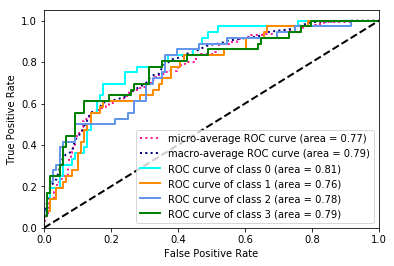

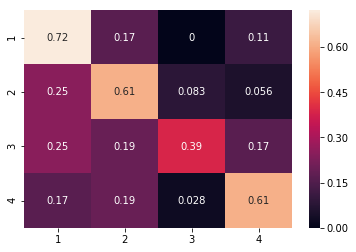

(631200, 60)
(960, 125, 60)
{'rmse': 2.2708333333333335, 'tr_acc': 0.5046296296296297, 'acc': 0.3854166666666667, 'pre': array([0.33333333, 0.33333333, 0.16666667, 0.70833333]), 'rec': array([0.57142857, 0.36363636, 0.66666667, 0.31481481]), 'f1s': array([0.42105263, 0.34782609, 0.26666667, 0.43589744])}
k6b


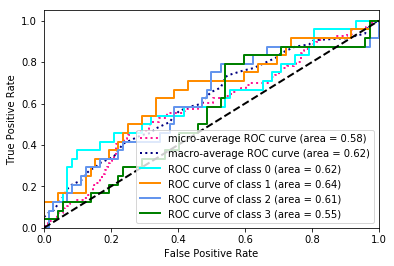

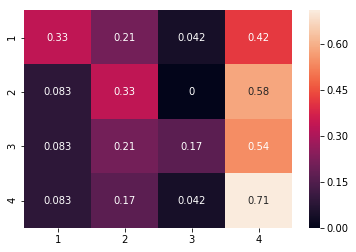

(633430, 60)
(960, 125, 60)
{'rmse': 2.2083333333333335, 'tr_acc': 0.5879629629629629, 'acc': 0.40625, 'pre': array([0.41666667, 0.79166667, 0.16666667, 0.25      ]), 'rec': array([0.34482759, 0.40425532, 0.57142857, 0.46153846]), 'f1s': array([0.37735849, 0.53521127, 0.25806452, 0.32432432])}
l1b


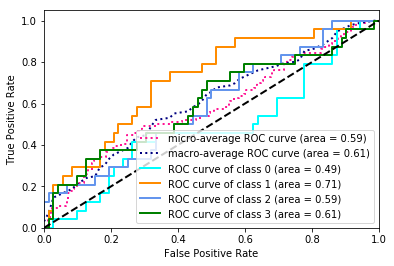

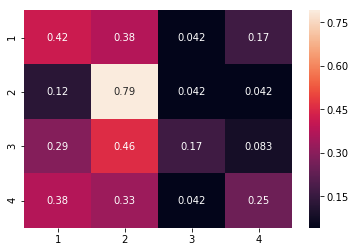

In [13]:
reports = []
for subject in ['k3b', 'k6b', 'l1b']:
    reports.append(evaluate(subject, window_size=125, stride=125))

In [14]:
reports

[{'rmse': 1.3472222222222223,
  'tr_acc': 0.7808641975308642,
  'acc': 0.5833333333333334,
  'pre': array([0.72222222, 0.61111111, 0.38888889, 0.61111111]),
  'rec': array([0.52      , 0.52380952, 0.77777778, 0.64705882]),
  'f1s': array([0.60465116, 0.56410256, 0.51851852, 0.62857143])},
 {'rmse': 2.2708333333333335,
  'tr_acc': 0.5046296296296297,
  'acc': 0.3854166666666667,
  'pre': array([0.33333333, 0.33333333, 0.16666667, 0.70833333]),
  'rec': array([0.57142857, 0.36363636, 0.66666667, 0.31481481]),
  'f1s': array([0.42105263, 0.34782609, 0.26666667, 0.43589744])},
 {'rmse': 2.2083333333333335,
  'tr_acc': 0.5879629629629629,
  'acc': 0.40625,
  'pre': array([0.41666667, 0.79166667, 0.16666667, 0.25      ]),
  'rec': array([0.34482759, 0.40425532, 0.57142857, 0.46153846]),
  'f1s': array([0.37735849, 0.53521127, 0.25806452, 0.32432432])}]

In [5]:
from keras import backend as K
def get_activations(model, layer, X_batch):
    get_activations = K.function([model.layers[0].input, K.learning_phase()], [model.layers[layer].output,])
    activations = get_activations([X_batch,0])
    return activations
def getFeatures(subject, window_size, stride):
    X, y = getData(subject, window_size=window_size, stride=stride)
    y = np.array(y)
    filepath="weights/CNN/new/16-0.5-32-0.5-64-0.5--" + subject + "-weights.hdf5"
    model = load_model(filepath)
    activations = get_activations(model, -2, X)
    return activations[0]

In [10]:
X, y = getData('l1b', window_size=125, stride=100)
activation = getFeatures('l1b', 125, 100)
activation = np.array(activation)
print(activation.shape)
df = pd.DataFrame(data = activation)
df = df.assign(labels = pd.Series(y, index=df.index).values)

(633430, 60)
(1196, 125, 60)
(633430, 60)
(1196, 125, 60)
(1196, 6720)


In [11]:
df.to_csv('l1b_cnn.csv', index=False)